# Exploring Bike Accident Data for Berlin

first visualization and exploration of destatis accident data, filtering for bicycle accidents 

## About the Data Set
* source: [Destatis Unfallatlas](https://unfallatlas.statistikportal.de/)
* [Licence](http://www.govdata.de/dl-de/by-2-0)
* for timespan of 2016-2024
* The Accident Atlas contains accidents with personal injury! Accidents involving only material damage are not shown.


In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import pyarrow as pa  


## Read data from csv-files 

In [4]:
csv_dir = Path("data/csv")
csv_files = sorted(csv_dir.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {csv_dir.resolve()}")

dfs = []
for fp in csv_files:
    df = pd.read_csv(fp, low_memory=False, delimiter=";", decimal=",")
    df["source_file"] = fp.name 
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(csv_files)} files -> combined shape: {df_all.shape}")

df_all.drop(columns=["OBJECTID", "UIDENTSTLA", "OBJECTID_1", "UIDENTSTLAE", "OID_", "FID", "IstStrasse", "LICHT"], inplace=True)

df_all.head()

Loaded 9 files -> combined shape: (2098019, 35)


,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,...,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,source_file,ULICHTVERH,IstGkfz,IstSonstige,IstStrassenzustand,PLST
0,1,0,55,12,2017,1,5,6,2,9,...,605079.4229,6.001758e+06,10.609031,54.153150,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
1,1,0,60,53,2017,1,6,6,3,6,...,582297.2184,5.969289e+06,10.251498,53.865551,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
2,1,0,61,11,2017,1,18,6,3,7,...,522799.3000,5.990576e+06,9.348344,54.062897,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
3,1,0,55,42,2017,1,12,7,3,5,...,616128.9378,5.981557e+06,10.770405,53.969302,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
4,1,0,62,60,2017,1,8,6,3,2,...,581575.9987,5.934905e+06,10.231475,53.556684,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN


In [5]:
# drop all accidents that did not involve bicycles (column 'IstRad' != 1)
df_bike = df_all[df_all['IstRad'] == 1].copy()
print(f"Filtered to bicycle accidents -> shape: {df_bike.shape}")

# only keep accidents in Berlin (column 'ULAND' == 11)
df_bike_berlin = df_bike[df_bike['ULAND'] == 11].copy()
print(f"Filtered to bicycle accidents in Berlin -> shape: {df_bike_berlin.shape}")
df_bike_berlin.head()

Filtered to bicycle accidents -> shape: (626844, 27)
Filtered to bicycle accidents in Berlin -> shape: (33181, 27)


,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,...,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,source_file,ULICHTVERH,IstGkfz,IstSonstige,IstStrassenzustand,PLST
307975,11,0,3,3,2018,1,15,4,3,6,...,798261.3849,5.835047e+06,13.403228,52.583472,Unfallorte2018_LinRef.csv,1.0,0.0,NaN,NaN,NaN
308120,11,0,3,3,2018,1,11,5,3,5,...,800551.7210,5.829808e+06,13.432186,52.535255,Unfallorte2018_LinRef.csv,0.0,0.0,NaN,NaN,NaN
308130,11,0,2,2,2018,1,8,2,3,5,...,803320.7292,5.827627e+06,13.470897,52.514173,Unfallorte2018_LinRef.csv,0.0,0.0,NaN,NaN,NaN
308149,11,0,1,1,2018,1,19,4,3,5,...,798174.6913,5.826940e+06,13.394673,52.510848,Unfallorte2018_LinRef.csv,2.0,0.0,NaN,NaN,NaN
308175,11,0,9,9,2018,1,18,4,2,5,...,806109.6297,5.821644e+06,13.506372,52.458993,Unfallorte2018_LinRef.csv,2.0,0.0,NaN,NaN,NaN


## First Explorative Plots
### Accidents by Weekday

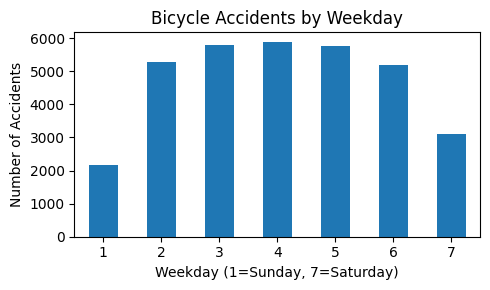

In [6]:
# plot number of accidents by weekday ('UWOCHENTAG')
weekday_counts = df_bike_berlin['UWOCHENTAG'].value_counts().sort_index()

plt.figure(figsize=(5, 3))
weekday_counts.plot(kind='bar')
plt.xlabel('Weekday (1=Sunday, 7=Saturday)')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Weekday')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Accidents by hour of the day

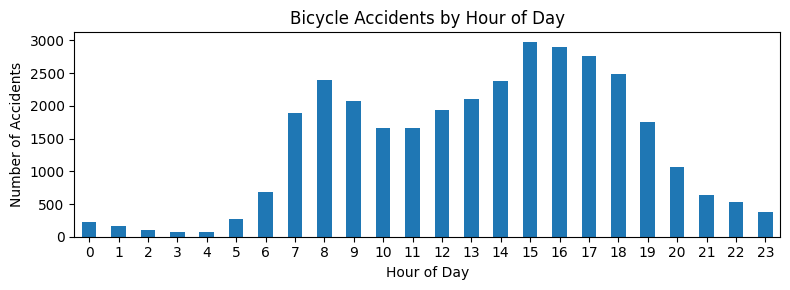

In [7]:
# plot number of accidents by hour of day ('USTUNDE')
hour_counts = df_bike_berlin['USTUNDE'].value_counts().sort_index()
plt.figure(figsize=(8, 3))
hour_counts.plot(kind='bar')    
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Hour of Day')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Accidents by Month

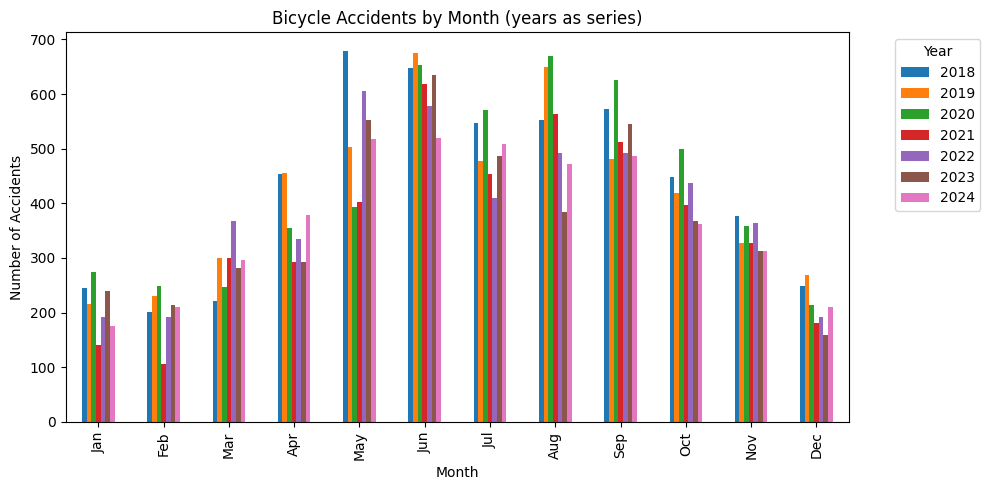

In [8]:
# plot months on the x-axis and years as series (switch year and month)
month_year_counts = df_bike_berlin.groupby(['UMONAT', 'UJAHR']).size().unstack(fill_value=0)
month_year_counts = month_year_counts.sort_index()

# replace numeric month index with short names for readability
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_year_counts.index = month_year_counts.index.map(lambda m: month_names[m-1] if 1 <= m <= 12 else str(m))

month_year_counts.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Month (years as series)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
  

### Severity of Injuries
* Seperated in three categories:
    1) Accident with persons killed
    2) Accident with seriously injured
    3) Accident with slightly injured

<Figure size 2800x500 with 0 Axes>

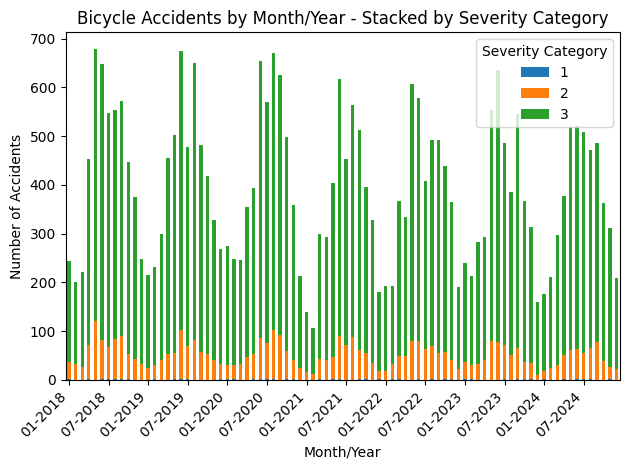

In [9]:
# plot stacked bar chart of accident severity by month/year
# create date column for grouping by month and year
df_bike_berlin['date'] = pd.to_datetime({'year': df_bike_berlin['UJAHR'], 'month': df_bike_berlin['UMONAT'], 'day':1})

# group by date and severity category
severity_date_counts = df_bike_berlin.groupby(['date', 'UKATEGORIE']).size().unstack(fill_value=0)
plt.figure(figsize=(28, 5))
severity_date_counts.plot(kind='bar', stacked=True)
plt.xlabel('Month/Year')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Month/Year - Stacked by Severity Category')
plt.legend(title='Severity Category')

# Set x-axis ticks to every sixth month with year and month labels
ax = plt.gca()
ticks = range(0, len(severity_date_counts), 6)
labels = [severity_date_counts.index[i].strftime('%m-%Y') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Bike Accidents over Time

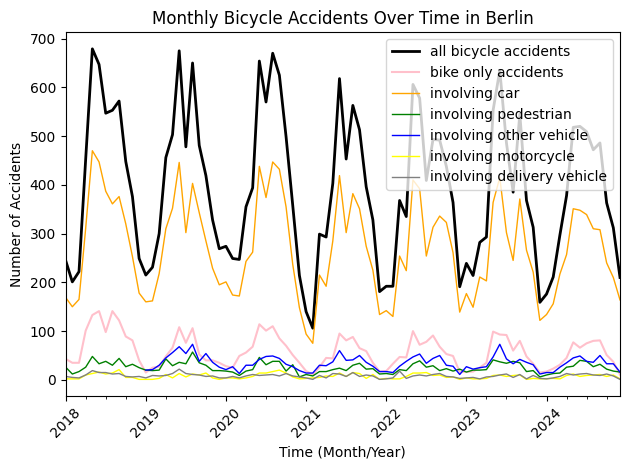

In [10]:
# plot curve on accident numbers over years with granularity of months
# add date column to dataframe, set day to 1 for all entries because no actual date info is available
df_bike_berlin['date'] = pd.to_datetime({'year': df_bike_berlin['UJAHR'], 'month': df_bike_berlin['UMONAT'], 'day':1})

monthly_counts_all = df_bike_berlin.groupby('date').size()
monthly_counts_all.plot(color='black', label='all bicycle accidents', linewidth=2)
monthly_counts_bike_only = df_bike_berlin[(df_bike_berlin['IstPKW'] != 1) & (df_bike_berlin['IstFuss'] != 1) & (df_bike_berlin['IstSonstige'] != 1) & (df_bike_berlin['IstKrad'] != 1) & (df_bike_berlin['IstGkfz'] != 1)].groupby('date').size()
monthly_counts_bike_only.plot(color='pink', label='bike only accidents')

subgroups = [['IstPKW', 'orange', 'involving car'],
             ['IstFuss', 'green', 'involving pedestrian'],
             ['IstSonstige', 'blue', 'involving other vehicle'],
             ['IstKrad', 'yellow', 'involving motorcycle'],
             ['IstGkfz', 'gray', 'involving delivery vehicle']]
for group, color, name in subgroups:
    monthly_counts_subgroup = df_bike_berlin[df_bike_berlin[group] == 1].groupby('date').size()
    monthly_counts_subgroup.plot(label=name, color=color, linewidth=1)

plt.legend()
plt.xlabel('Time (Month/Year)')
plt.ylabel('Number of Accidents')
plt.title('Monthly Bicycle Accidents Over Time in Berlin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Map with Dots for each Bike Accident
* creates map with dots for each accident
* colors representing accident opponent vehicle:
    * orange: car
    * green: pedestrian
    * yellow: motorcycle
    * gray: goods road vehicle
    * blue: other vehicle (e.g. bus or tram)
    * beige: only bicycle involved

In [11]:
# map accident locations using folium
map_center = [52.52, 13.40]  # Center of Berlin
accident_map = folium.Map(location=map_center, zoom_start=12) 
for _, row in df_bike_berlin.iterrows():
    lat = row['YGCSWGS84']  
    lon = row['XGCSWGS84']  
    if pd.notnull(lat) and pd.notnull(lon):
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            # set color according to involvement of car or pedestrian or other vehicles
            color='orange' if row['IstPKW'] == 1 else 'green' if row['IstFuss'] == 1 else 'yellow' if row['IstKrad'] == 1 else 'gray' if row['IstGkfz'] == 1 else 'blue' if row['IstSonstige'] == 1 else 'beige',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(accident_map)
accident_map.save("bicycle_accidents_berlin.html")


In [12]:
#create heat map of accident locations
heat_data = df_bike_berlin[["YGCSWGS84", "XGCSWGS84"]].values.tolist()
m = folium.Map(location=[52.52, 13.40], zoom_start=15)
HeatMap(heat_data, radius=15).add_to(m)
m.save("bicycle_accidents_heatmap_berlin.html")

## Clean Dataset for Accidents with locations outside the Strava Streetsegments

In [ ]:
# import berlin_data.parquet file
strava_segments_berlin = Path("data/parquet/berlin_data.parquet")
strava_segments = pd.read_parquet(path=str(strava_segments_berlin))

ArrowKeyError: A type extension with name pandas.period already defined